Created 6/21/2023

The purpose of this notebook is to push towards getting the final assembly of the simulated fields working. It will only call from the .py file versions of functions and classes, and will attempt to demonstrate full functionality from the beginning to the end of created a simulated data product.

I'm also going to treat this kind of like building up a tutorial notebook, because I think that will be useful later.

In [68]:
# imports
# %matplotlib widget
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import astropy.wcs as wcs
# import pandas as pd
# import copy
# import random
# import imp

# import butterpy as bp
import trc_funcs as trc
import field
import generator_classes as gen
# import PRF

# from astropy import units as u
# from astropy.coordinates import SkyCoord
# from astroquery.mast import Tesscut
# from astropy.stats import sigma_clip
from scipy import stats
# import scipy.signal
# import astropy.table

plt.rcParams.update({'figure.facecolor': 'white', 'axes.facecolor': 'white', 'savefig.facecolor': 'white'})


In [2]:
import tinygp

In [3]:
import imp
imp.reload(trc)
imp.reload(field)
# imp.reload(gen)

<module 'field' from '/Users/raeholcomb/Documents/GitHub/sset/sset/field.py'>

## Set up your Generator Functions

Let's set up some code to inject variability into our background stars. To do this, we will use two types of objects: timeseries generators (which subclass from `TSGenerator`) and a function selector (`FunctionSelector`). TS generators store the code needed to caluate flux variability with different functional forms. The function selector is alike a library of TS generators, where each generator is given a probabilistic weight. When called, the function selector will use these weights to choose a generator, which will then generate a time series that can be injected into a stellar source.

Later: add more about the inputs to FS and TSG, and how to subclass a TSG.
TSG signals should be normalized to 1.

For the TSG, the only functions that need to be overwritten are:
- `__init__`: Provide default values for any necessary parameters.
- `__repr__`: Provide a name for the class
- `functional_form`: This function takes in a time array and a dictionary of parameter values, and outputs the flux and the dictionary of parameter values.

**Notes for next time:**
- Need to pass along name information when FS.generate_signal is called
- Need to implement a way to store the params in Field
- Consider: should functional_form out put the parameter values? It isn't necessary, but is it good to keep the output consistent with `generate_signal`?

**Notes for other stuff next time:**
- Need to add offset function for each source

TO DO: 
- define a table that will track all the values used to make this field
- source, position, variability function, params, offset
- ideally, you should be able to feed this table into a Field object and recreate the same field
- hm.... will have to think about implementation
- Maybe: add a function to the field class that can read in that table and populate the sources accordingly

In [4]:
imp.reload(gen)

<module 'generator_classes' from '/Users/raeholcomb/Documents/GitHub/sset/sset/generator_classes.py'>

In [5]:
# Set up the sine function generator
sine1 = gen.SineTSGenerator('sine1', 
                            params={'A':stats.uniform(loc=-.05, scale=.1), 
                                    'B':stats.uniform(loc=1, scale=5),
                                    'C':stats.uniform(loc=0, scale=2*np.pi), 
                                    'D':1})
time = np.array(np.linspace(0,1,10))

# print(sine1.sample())
time1 = np.linspace(0,10,1000)
sin_flux, sin_params = sine1.generate_signal(time1)

# print(sin_params)
# plt.plot(time1, sin_flux)
# plt.show()

In [6]:
# Set up the eclipsing binary generator
eb1 = gen.EclipsingBinaryTSGenerator('eb1', params={'radius_1':.15})
print(eb1.sample())
print(eb1.generate_signal(time))

{'radius_1': 0.15, 'radius_2': 0.17135138422552854, 'incl': 82.27186460110627, 'ecc': 0.1546815392661136, 'om': 0.0, 'period': 1.0920460185956116, 'sbratio': 1.5414808799919624, 't_zero': 0.9765142013230725}
(array([0.61438534, 0.68279188, 0.91080957, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), {'radius_1': 0.15, 'radius_2': 0.21168635797162622, 'incl': 88.03609974461618, 'period': 4.554802240593596, 'sbratio': 1.6620756275966533, 't_zero': 2.42691407658886, 'f_c': -0.20243817349673054, 'f_s': 0.0})


In [7]:
imp.reload(gen)

<module 'generator_classes' from '/Users/raeholcomb/Documents/GitHub/sset/sset/generator_classes.py'>

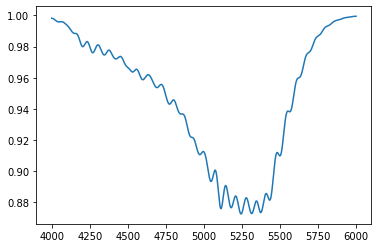

In [8]:
# set up the butterpy generator
time1 = np.arange(4000, 6000, .5)
bp1 = gen.ButterpyTSGenerator('bp1')
# print(bp1.sample())
# print(bp1.generate_signal(time1))
flux1, dict1 = bp1.generate_signal(time1)

plt.plot(time1, flux1)
plt.show()

In [9]:
dict1
# bp1.sample()

{'butterfly': True,
 'activity_rate': 3.3786661423853115,
 'cycle_length': 16.49249741989805,
 'cycle_overlap_lowerbound': 0.1,
 'decay_time': 1,
 'min_ave_lat': 14.3882369310761,
 'max_ave_lat_upperbound': 80,
 'alpha_med': 0.0009,
 'period': 54.06166102633707,
 'incl': 0.30721266275118964,
 'decay_timescale': 3.56035846094188,
 'diffrot_shear': 1,
 'tsim': 1825,
 'tstart': 0,
 'max_ave_lat': 35.801786741103214,
 'cycle_overlap': 0.5399647093142871}

In [10]:
# set up the function selector
fs = gen.FunctionSelector([(sine1,10), (eb1,10), (bp1,10)])
# fs.add_generator(sine1, 10)

# fs.select_generator()
time = np.array(np.linspace(0,1,10))
# gen.SineTSGenerator().generate_signal(time)
fs.instantiate_function(time)
# fs.select_generator()
# print(fs)

# fs.select_generator()

# time = np.linspace(1,10,200)
# flux, params = fs.instantiate_function(time)
# plt.plot(time,flux)
# plt.show()


('bp1',
 array([0.98803836, 0.98803893, 0.98803965, 0.9880393 , 0.98803878,
        0.98803846, 0.98803837, 0.98803852, 0.98803867, 0.98803881]),
 {'butterfly': True,
  'activity_rate': 0.2538519304949497,
  'cycle_length': 2.6105599185911745,
  'cycle_overlap_lowerbound': 0.1,
  'decay_time': 1,
  'min_ave_lat': 6.560443575156163,
  'max_ave_lat_upperbound': 80,
  'alpha_med': 0.0009,
  'period': 72.91945977521728,
  'incl': 0.4268505945722888,
  'decay_timescale': 9.811775566406746,
  'diffrot_shear': 1,
  'tsim': 1825,
  'tstart': 0,
  'max_ave_lat': 57.86660449010862,
  'cycle_overlap': 0.23040403589871863})

## tinygp dev

In [161]:
import jax
jax.config.update("jax_enable_x64", True)


In [158]:
def plot_kernel(kernel, **kwargs):
    dx = np.linspace(0, 5, 100)
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    plt.xlabel("dx")
    plt.ylabel("k(dx)")




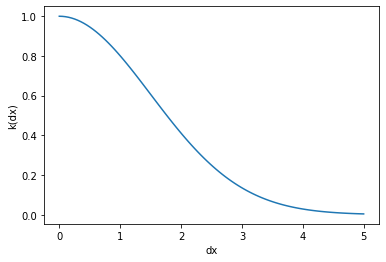

In [159]:
from tinygp import GaussianProcess
from tinygp import kernels

# define kernel
kernel = kernels.ExpSquared(scale=1.5)
plot_kernel(kernel)

# Let's make up some input coordinates (sorted for plotting purposes)
X = np.sort(np.random.default_rng(1).uniform(0, 10, 100))

gp = GaussianProcess(kernel, X)


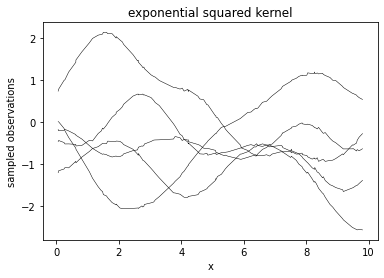

In [170]:
y = gp.sample(jax.random.PRNGKey(8), shape=(5,))
plt.plot(X, y.T, color="k", lw=0.5)
plt.xlabel("x")
plt.ylabel("sampled observations")
_ = plt.title("exponential squared kernel")

## Download Data

Let's begin by downloading some data. Every simulated TPF is based on a real TESS field, which allows us to build up the simulated images with realistic source positions, fluxes, and background features. Here we use the Lightkurve package to download:
- An FFI cutout, of the size we want the final simulated image to be. This image will provide us with information on the background, the positional data (neede for calculating differential velocity aberrations), and header information.
-  A pipeline target pixel file, centered on the same target as the FFI cutout. This is not strictly necessary, but it will provide us with aperture information which we can use when extracting a light curve from our simulated image.
- A catalog of sources within our FFI cutout.

In [11]:
# download data: tpf_pl, tpf_cutout, and source_cat
# pick a star/field to work with
tic = 396696273
name = "TIC " + str(tic)

# postage stamp tpf from pipeline
tpf_pl = lk.search_targetpixelfile(name, sector=3, exptime=1800).download(quality_bitmask="hard")

# grab the TESS FFI cut out
cutout_size=20
tpf_cutout = trc.get_cutout(name, cutout_size=cutout_size)

# grab the catalog of sources
source_cat = trc.get_catalog(name, cutout_size=cutout_size)


/opt/anaconda3/lib/python3.8/site-packages/lightkurve/search.py:407: LightkurveWarning: Warning: 7 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


In [4]:
tpf_cutout.animate()

## Assemble Field

To assemble a Field object

Initialize with the following:
- 

Then you need to call:
- self.calc_bkg(polyorder=3)
- add_sources()
    - idx=0 will be the star at the center of your TPF. We recommend doing random_signal=False and signal_func=(your desired TSGenerator) for this star.
    - Then you can use random_signal=True to use the FunctionSelector to randomly populate your background stars
    - 

In [42]:
imp.reload(trc)
imp.reload(field)
imp.reload(gen)

<module 'generator_classes' from '/Users/raeholcomb/Documents/GitHub/sset/sset/generator_classes.py'>

In [43]:
# test Field class
# def signal_test(time):
#     """Placeholder for a signal added to a star"""
#     return 1 + 0.1 * np.sin(time * np.random.uniform(.5, 1.5))

# test = signal_test(tpf_cutout.time.value)
# plt.plot(tpf_cutout.time.value, test)
# plt.show()

# type(source_cat)

field1 = field.Field(tpf_cutout, source_cat , bkg_polyorder=2,
                     bkg_variability_generator=fs, 
                     pos_time=tpf_pl.time.value, 
                     pos_corr1=tpf_pl.pos_corr1, 
                     pos_corr2=tpf_pl.pos_corr2, 
                     noise_func=trc.exponential, 
                     noise_coeffs=np.array([ 0.00309107,  2.238249  , -0.0438357 ]),
                     add_offset=True)

field1.calc_bkg(polyorder=2)

In [44]:
field1.add_signal(0, random_signal=True)
field1.add_signal(np.arange(1,len(field1.source_catalog)), random_signal=True)




In [45]:
field1.calc_empirical_noise()
field1.assemble()
field1.to_tpf().animate(clim=[120,260])

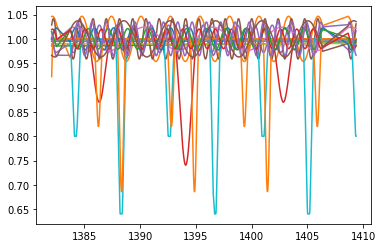

In [69]:
for ind in range(len(field1.signals1D)):
    plt.plot(field1.orig_tpf.time.value, field1.signals1D[ind])
plt.show()

In [4]:
# assemble field
# probably need to add in stand ins for the empirical noise model and the LC pipeline

# later add in something to pick the field

In [102]:
imp.reload(trc)
imp.reload(field)
imp.reload(gen)

<module 'generator_classes' from '/Users/raeholcomb/Documents/GitHub/tess_sim/tess_sim/generator_classes.py'>

In [68]:
np.random.normal(loc=1., scale=.0125, size=None)
field1.source_catalog['offset'] = field1.generate_offset(size=len(field1.source_catalog))

In [ ]:
# mess around with the source_cat
sc = source_cat.copy()['ID', 'ra', 'dec', 'pmRA', 'pmDEC', 'Tmag', 'GAIA', 'contratio', 'dstArcSec']
sc[:3]

<Table length=3>
    ID           ra               dec        ... contratio      dstArcSec    
   str9       float64           float64      ...  float64        float64     
--------- ---------------- ----------------- ... ---------- -----------------
396696273 65.3022779524928 -55.1440218215514 ... 0.04365064               0.0
396696276 65.2967867766935 -55.1550175340301 ...        nan 41.16484036924621
396696267 65.2754685020188  -55.124256141076 ...        nan 90.04050066606608

In [ ]:
# add columns for the Tflux, pixel positions, variability function, params, and offset

# flux
sc['Tflux'] = trc.mag_to_flux(sc['Tmag'])

# pix1, pix2 = self.orig_tpf.wcs.all_world2pix(self.source_cat['ra'], self.source_cat['dec'], 0)
pix1, pix2 = tpf_cutout.wcs.all_world2pix(sc['ra'], sc['dec'], 0)


# pixel positions
sc['pix1'] = pix1
sc['pix2'] = pix2
sc['pix1int'] = np.rint(pix1).astype(int)
sc['pix2int'] = np.rint(pix2).astype(int)

# variability columns
sc['signal_function'] = None
sc['signal_params'] = {}
sc['offset'] = 1.

sc


<Table length=20>
    ID           ra               dec        ... signal_params  offset
   str9       float64           float64      ...     object    float64
--------- ---------------- ----------------- ... ------------- -------
396696273 65.3022779524928 -55.1440218215514 ...            {}     1.0
396696276 65.2967867766935 -55.1550175340301 ...            {}     1.0
396696267 65.2754685020188  -55.124256141076 ...            {}     1.0
396696266 65.2773671059442 -55.1227399886111 ...            {}     1.0
396696265 65.2844009032428 -55.1189121967341 ...            {}     1.0
396696262 65.3014634903041 -55.1131088158423 ...            {}     1.0
396696271 65.2435241580431  -55.137994675283 ...            {}     1.0
396696261 65.3449250853431 -55.1071646927391 ...            {}     1.0
396696260 65.2921908453684 -55.0981598570627 ...            {}     1.0
396696286 65.2981915271218 -55.1908202890712 ...            {}     1.0
396696283    65.3706884937 -55.1735512743813 ...            {}     1.0
396696282 65.2112084559182 -55.1724946197903 ...            {}     1.0
396696285 65.2322168588702  -55.189977785545 ...            {}     1.0
396695718 65.1901717387146 -55.1689133625774 ...            {}     1.0
396696256 65.3019963081555 -55.0716037584176 ...            {}     1.0
396720649 65.4188113433969  -55.178160304447 ...            {}     1.0
396696287 65.2496081080575 -55.2173011882146 ...            {}     1.0
396696257 65.4025545775929 -55.0888452210485 ...            {}     1.0
396720662        65.440385        -55.122144 ...            {}     1.0
396720647 65.4324811521725 -55.1794332366507 ...            {}     1.0

In [122]:
imp.reload(gen)
imp.reload(trc)
imp.reload(field)


<module 'field' from '/Users/raeholcomb/Documents/GitHub/tess_sim/tess_sim/field.py'>

In [40]:
# set up an array that stores all the 1D signals that get added
print(len(sc))
print(len(tpf_cutout.time))
signals = np.ones((len(sc),len(tpf_cutout.time)))
print(np.shape(signals))

# generate a signal and add it to the sources matrix
type(fs.generators[fs.select_generator()])

20
1077
(20, 1077)


generator_classes.SineTSGenerator

In [98]:
idx = 1
idx = np.array([idx])

for row in sc[idx]:
    print(type(row))
    print(row['ID'])

        ID [3]                        ra [3]                               dec [3]                      pmRA [3]          pmDEC [3]           Tmag [3]                       GAIA [3]                  contratio [3]              dstArcSec [3]                             Tflux [3]                               pix1 [3]                                pix2 [3]                pix1int [3] pix2int [3] signal_function [3] signal_params [3] offset [3]
---------------------- ------------------------------------ -------------------------------------- ------------------ ------------------ ------------------ ------------------------------------------ ------------- --------------------------------------- --------------------------------------- -------------------------------------- --------------------------------------- ----------- ----------- ------------------- ----------------- ----------
396696276 .. 396696262 65.2967867766935 .. 65.3014634903041 -55.1550175340301 .. -55.1131088158423 6.26182 .. 

In [99]:
sc.columns

<TableColumns names=('ID','ra','dec','pmRA','pmDEC','Tmag','GAIA','contratio','dstArcSec','Tflux','pix1','pix2','pix1int','pix2int','signal_function','signal_params','offset')>

In [125]:
field1.bkg_variability_generator.instantiate_function(field1.orig_tpf.time.value)

(array([0.99832469, 0.99849328, 0.9986638 , ..., 1.00337733, 1.00324436,
        1.00310726]),
 {'A': 0.004984471708755454,
  'B': 1.7132496092888252,
  'C': 0.35853320620827245,
  'D': 1})

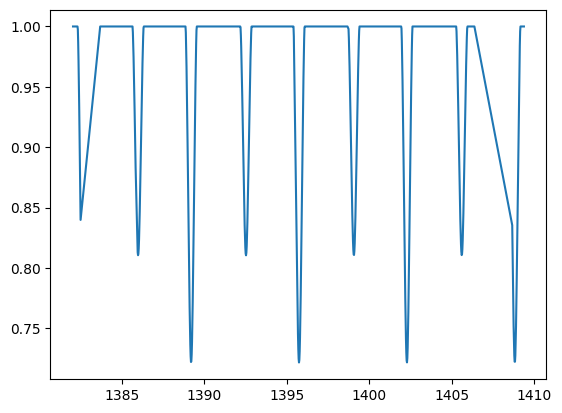

In [43]:
signal, params = field1.bkg_variability_generator.instantiate_function(field1.orig_tpf.time.value)

# add to signals1D array
signals1D[0,:] = signal

# plt.plot(field1.orig_tpf.time.value, signal)
plt.plot(field1.orig_tpf.time.value, signals1D[0,:])
# plt.show()

In [62]:
imp.reload(field)

<module 'field' from '/Users/raeholcomb/Documents/GitHub/tess_sim/tess_sim/field.py'>

In [74]:
# test Field class
def signal_test(time):
    """Placeholder for a signal added to a star"""
    return 1 + 0.1 * np.sin(time * np.random.uniform(.5, 1.5))

# test = signal_test(tpf_cutout.time.value)
# plt.plot(tpf_cutout.time.value, test)
# plt.show()

# type(source_cat)

field1 = field.Field(tpf_cutout, source_cat , bkg_polyorder=2,
                     bkg_variability_generator=fs, 
                     pos_time=tpf_pl.time.value, pos_corr1=tpf_pl.pos_corr1, pos_corr2=tpf_pl.pos_corr2, noise_func=trc.exponential, noise_coeffs=np.array([ 0.00309107,  2.238249  , -0.0438357 ]))
field1.calc_bkg()
# field1.add_signal(signal_test)
# field1.calc_empirical_noise()
# field1.assemble()
# field1.to_tpf().animate(clim=[120,260])

## Lightcurve Extration

In [ ]:
# two different approaches to lc extraction
# 1. Dax's way, uses a threshold mask
# 2. Christina's way, uses the prf to do a cumulative sum to get 90% of the flux

In [51]:
ffi1 = field1.to_tpf()

In [50]:
imp.reload(trc)
imp.reload(field)
imp.reload(gen)

<module 'generator_classes' from '/Users/raeholcomb/Documents/GitHub/sset/sset/generator_classes.py'>

### Dax's Method

In [66]:
Sector = ffi1.get_header()['SECTOR']
ID = 1111
cutoutsize=cutout_size
name='Test1'

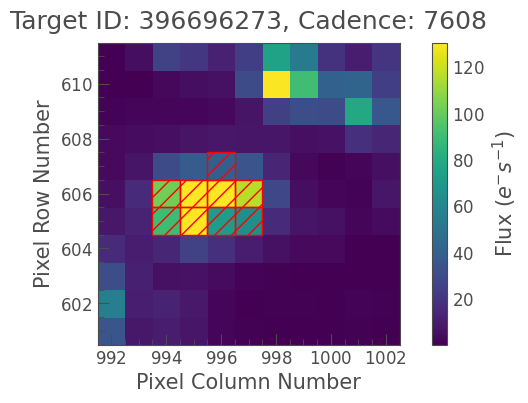

In [62]:
# plot the pipeline mask
tpf_pl.plot(aperture_mask=tpf_pl.create_threshold_mask(threshold))
plt.show()

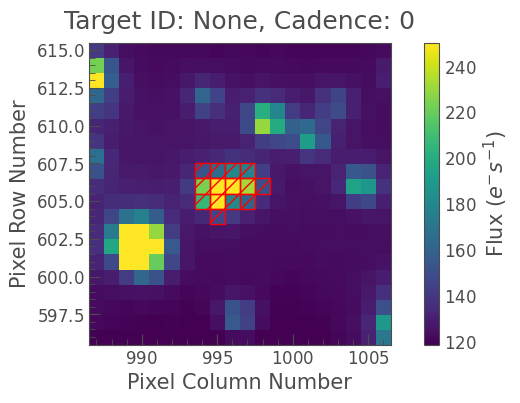

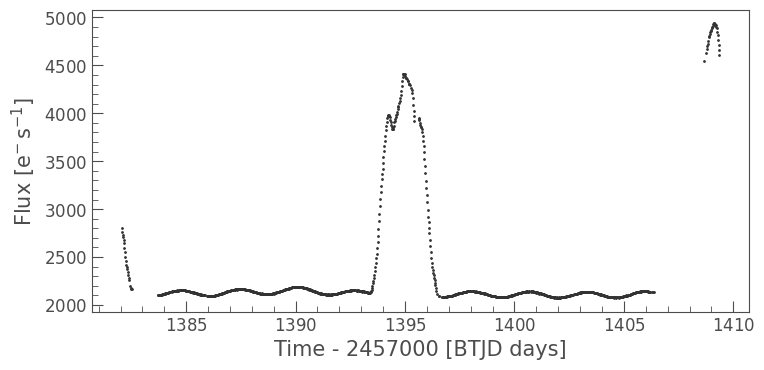

In [61]:
threshold=3

# plot the threshold mask for the sim tpf
ffi1.plot(aperture_mask=ffi1.create_threshold_mask(threshold))
plt.show()

star1 = ffi1.to_lightcurve(aperture_mask=ffi1.create_threshold_mask(threshold))
star1.scatter()
plt.show()

selected aperture mask is  1.97 pixels from reference pixel! Using circular aperture (r = 1.5 pixels) around reference pixel instead
selected threshold:  3
len check   T 1077  SAP 1077  E  1077
shape check   T (1077,)  SAP (1077,)  E  (1077,)
electron / s electron / s
RAW len check: 1077 1077 1077


/Users/raeholcomb/Documents/GitHub/sset/sset/trc_funcs.py:707: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.html
  SAP_LC.mission=mission


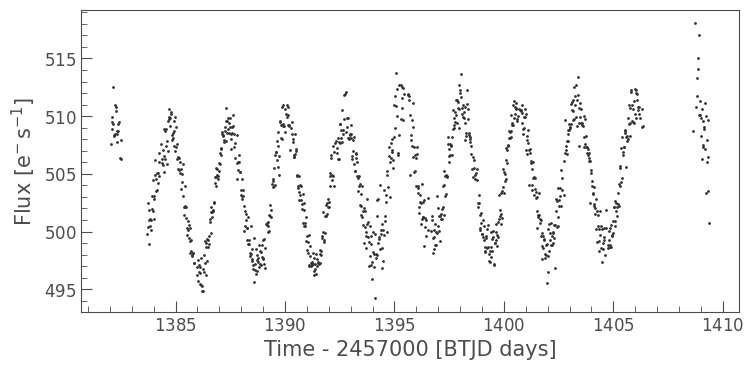

In [67]:
hdu = ffi1.hdu
quality_mask = hdu[1].data['QUALITY']!=0
cadence='30 minute'
if (cadence=='short') or (cadence=='fast') or (cadence=='2 minute') or (cadence=='20 second') :
    x=hdu[1].header['1CRPX4']-1 # in this case, TPFs are already centered
    y=hdu[1].header['2CRPX4']-1 # subtracting by one places coord on center, from testing they're always off by 1...
if (cadence=='long') or (cadence=='30 minute') or (cadence=='10 minute'):
    x=hdu[1].header['1CRPX4']-0.5 #subtracting by 0.5 places coord on center of pixel
    y=hdu[1].header['2CRPX4']-0.5 #otherwise it's on corner of pixel
reference_pixel=[x,y]
verbose=True

#defining time scale from FFI Raw LC
fmt=star1.time.format; scale=star1.time.scale
flux_unit = star1.flux.unit
mission=star1.mission
sap_lc = trc.SAP(ID,Sector,cutoutsize,hdu,quality_mask,
             threshold,cadence,reference_pixel,
             verbose,fmt,scale,flux_unit,mission,
             use_SPOC_aperture=False,
             use_centroid=False,use_circ=True,
             use_sources_in_aperture=False)
sap_lc.scatter()
plt.show()

### Christina Method

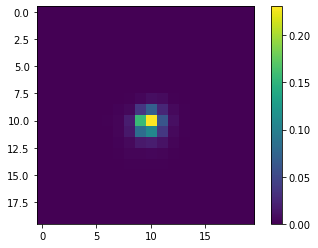

In [110]:
# arr = field1.prf.locate(5, 5, field1.shape)
arr = field1.prf.locate(field1.source_catalog[0]['pix1'], field1.source_catalog[0]['pix2'], field1.shape)
plt.imshow(arr)
plt.colorbar()



In [99]:
def generate_mask(array_2d, threshold):
    """Generates an aperture mask based on the expected source PRF. Returns the mask and the expected flux fraction of the aperture."""
    # Flatten the 2D array and create a mask with the same shape
    flat_array = array_2d.flatten()
    mask = np.zeros_like(flat_array, dtype=bool)
    
    # Get indices that would sort the array in descending order
    sorted_indices = np.argsort(flat_array)[::-1]
    
    # Iterate through sorted indices and update mask
    cumulative_sum = 0.0
    for idx in sorted_indices:
        cumulative_sum += flat_array[idx]
        mask[idx] = True
        if cumulative_sum > threshold:
            break
    
    # Reshape the mask to match the original 2D array shape
    mask = mask.reshape(array_2d.shape)
    
    return mask, cumulative_sum

# Example usage
threshold_value = 0.6
input_array = np.array([[0.2, 0.3, 0.4],
                        [0.1, 0.5, 0.6],
                        [0.8, 0.7, 0.9]])

result_mask, flfr = generate_mask(input_array, threshold_value)
print(result_mask)

[[False False False]
 [False False False]
 [False False  True]]


0.900632117751592


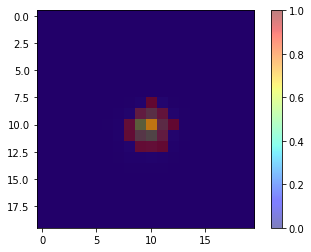

In [114]:
result_mask, flfr = generate_mask(arr, 0.9)
print(flfr)
# print(result_mask)

plt.imshow(arr)
plt.imshow(result_mask, cmap='jet', alpha=0.5) # interpolation='none'
plt.colorbar()

In [116]:
# calculate the crowdsap (crsp)
# crowdsap - the ratio of target flux relative to the total flux within the photometric aperture including contaminat-ing sources.

# do expected crowdsap based on the prfs in the source catalog?
np.shape(field1.signals2D[1])

def calc_crowdsap(tpf, s_ind, aper):
    """Given a field object, the index of a source in its source catalog, and an aperture, calculates the crowdsap within that aperture."""
    crowdflux = 0.

    for ind in range(len(tpf.source_catalog)):        
        row = tpf.source_catalog[ind]
        # get the prf
        try:
            source_prf = tpf.prf.locate(row['pix1']+np.median(tpf.pos_corr[0]), row['pix2']+np.median(tpf.pos_corr[1]), tpf.shape)
        except:
            print("Couldn't find PRF for target index " + str(ind))

        # multiply the prf by the Tflux, then add the contribution within the aperture
        # if this is our target star save as the source_flux, else it's crowding
        if ind == s_ind :
            sourceflux = np.sum((source_prf * row['Tflux'])[aper])
        else :
            crowdflux += np.sum((source_prf * row['Tflux'])[aper])

    # now calculate the flux from the source in the     
    return sourceflux / (crowdflux+sourceflux)

calc_crowdsap(field1, 0, result_mask)

        


0.5394621925868699